In [72]:
import numpy as np
from numpy import ndarray

from typing import Callable, Dict, Tuple, List

np.set_printoptions(precision=4)
# GRAPHS_IMG_FILEPATH = "/Users/seth/development/01_deep-learning-from-scratch/images/02_fundamentals/graphs/"

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
TEST_ALL = False

# 주택가격 데이터

In [75]:
from sklearn.datasets import load_boston

In [76]:
boston = load_boston()

In [77]:
data = boston.data
target = boston.target
features = boston.feature_names

# 싸이킷런으로 구현한 선형 회귀

## 데이터 준비

In [78]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

## 선형 회귀

In [80]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [81]:
import matplotlib.pyplot as plt
import matplotlib

plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rc('font', family='NanumGothic') # For Windows
matplotlib.rcParams['axes.unicode_minus'] = False
print(plt.rcParams['font.family'])

['NanumGothic']


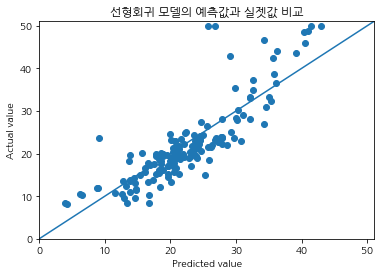

In [82]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("선형회귀 모델의 예측값과 실젯값 비교")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);
# plt.savefig(IMG_FILEPATH + "00_linear_real_pred_vs_actual.png");

## 특징값의 변화

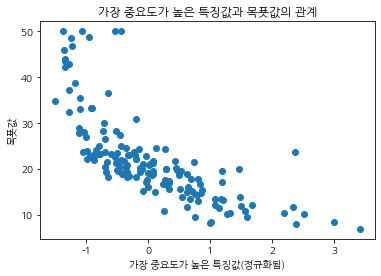

In [83]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("가장 중요도가 높은 특징값(정규화됨)")
plt.ylabel("목푯값")
plt.title("가장 중요도가 높은 특징값과 목푯값의 관계");
# plt.savefig(IMG_FILEPATH + "02_most_important_feature_vs_target.png")

선형적 관계가 아니다.

## 모델의 오차

In [84]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    평균절대오차 계산
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    '''
    제곱근 평균제곱오차 계산
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [85]:
print("평균제곱오차:", round(mae(preds, y_test), 4), "\n"
      "제곱근 평균제곱오차:", round(rmse(preds, y_test), 4))

평균제곱오차: 3.5671 
제곱근 평균제곱오차: 5.0476


In [86]:
import numpy as np
np.round(lr.coef_, 2)

array([[-1.01,  0.71,  0.28,  0.71, -2.21,  2.38,  0.71, -2.66,  2.63,
        -1.82, -2.33,  0.85, -4.19]])

## 선형회귀 직접 구현하기

In [88]:
def forward_linear_regression(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]
                              )-> Tuple[float, Dict[str, ndarray]]:
    '''
    선형회귀의 순방향 계산 과정
    '''
    # X와 y의 배치 크기가 같은지 확인
    assert X_batch.shape[0] == y_batch.shape[0]

    # 행렬곱 계산이 가능한지 확인
    assert X_batch.shape[1] == weights['W'].shape[0]

    # B의 모양이 1x1인지 확인
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # 순방향 계산 수행
    N = np.dot(X_batch, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y_batch - P, 2))

    # 순방향 계산 과정의 중간값 저장
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch

    return loss, forward_info

In [89]:
def to_2d_np(a: ndarray, 
             type: str = "col") -> ndarray:
    '''
    1차원 텐서를 2차원으로 변환
    '''

    assert a.ndim == 1, \
    "입력하는 텐서는 1차원이어야 함"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [90]:
def permute_data(X: ndarray, y: ndarray):
    '''
    X와 y를 axis=0 방향으로 짝이 맞도록 섞음
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [91]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    선형회귀 모형의 dLdW와 dLdB 계산
    '''
    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    # 여기서 행렬곱을 수행함
    # dNdW가 왼쪽에 와야 함(1장 마지막 부분 노트 참고)    
    dLdW = np.dot(dNdW, dLdN)

    # 배치 크기에 해당하는 차원 방향으로 합을 계산함
    # (1장 마지막 부분 노트 참고)    
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

In [92]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    주어진 위치부터 정해진 크기만큼의 X,y의 배치를 생성
    '''
    assert X.ndim == y.ndim == 2, \
    "X와 y는 2차원이어야 함"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [93]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:
    '''
    예측을 구하고 이에 대한 손실값을 계산한다
    (주로 추론시 사용됨)
    '''
    N = np.dot(X, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [94]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    첫 번째 순방향 계산을 위해 가중치를 초기화
    '''
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [95]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:
    '''
    정해진 횟수만큼의 에폭 동안 모델을 학습
    '''
    if seed:
        np.random.seed(seed)
    start = 0

    # 가중치 초기화
    weights = init_weights(X.shape[1])

    # 데이터 섞기
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # 배치 생성
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # 생성한 배치로 학습
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

In [96]:
train_info = train(X_train, y_train,
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

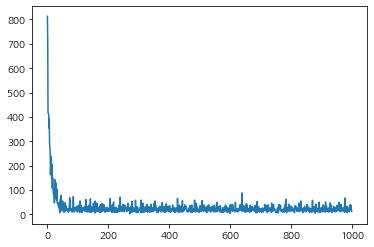

In [97]:
plt.plot(list(range(1000)), losses);

In [98]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    '''
    선형회귀 모델로 예측하기
    '''

    N = np.dot(X, weights['W'])

    return N + weights['B']

In [99]:
preds = predict(X_test, weights)

In [100]:
print("평균절대오차:", round(mae(preds, y_test), 4), "\n"
      "제곱근 평균제곱오차:", round(rmse(preds, y_test), 4))

평균절대오차: 3.5644 
제곱근 평균제곱오차: 5.0497


In [101]:
np.round(y_test.mean(), 4)

22.0776

In [102]:
np.round(rmse(preds, y_test) / y_test.mean(), 4)

0.2287

제곱근 평균제곱오차는 약 23%

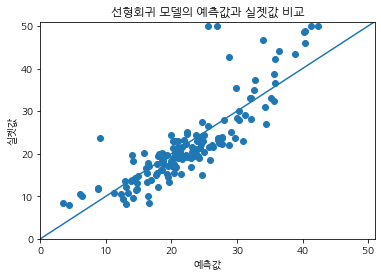

In [103]:
plt.xlabel("예측값")
plt.ylabel("실젯값")
plt.title("선형회귀 모델의 예측값과 실젯값 비교");
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);
# plt.savefig(GRAPHS_IMG_FILEPATH + "01_linear_custom_pred_vs_actual.png");

In [104]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

test_feature = np.concatenate([a, b], axis=1)
test_preds = predict(test_feature, weights)[:, 0]

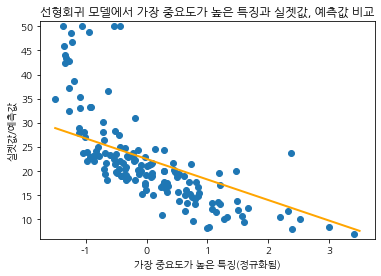

In [105]:
plt.scatter(X_test[:, 12], y_test)
plt.plot(np.array(test_feature[:, -1]), test_preds, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("가장 중요도가 높은 특징(정규화됨)")
plt.ylabel("실젯값/예측값")
plt.title("선형회귀 모델에서 가장 중요도가 높은 특징과 실젯값, 예측값 비교");
# plt.savefig(GRAPHS_IMG_FILEPATH + "03_most_important_feature_vs_predictions.png")

## 계수

In [106]:
np.round(weights['W'].reshape(-1), 4)

array([-1.0954,  0.7353,  0.1977,  0.7475, -2.2849,  2.2006,  0.7195,
       -2.6384,  2.5358, -1.6892, -2.3162,  0.8435, -4.2553])

In [107]:
np.round(lr.coef_, 4)

array([[-1.0148,  0.7065,  0.276 ,  0.7092, -2.206 ,  2.3793,  0.7133,
        -2.6625,  2.6325, -1.8172, -2.3266,  0.8465, -4.1889]])

In [108]:
np.round(weights['B'], 4)

array([[22.6312]])

In [109]:
np.round(lr.intercept_, 4)

array([22.6195])

계수는 싸이킷런으로 만든 선형회귀 모형과 직접 구현한 선형회귀 모형에서 모두 같았다.

## 가장 중요도가 높은 특징과 목푯값 사이의 이론적 관계

In [110]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

In [111]:
test_feature = np.concatenate([a, b], axis=1)
preds = predict(test_feature, weights)[:, 0]

(6.0, 51.0)

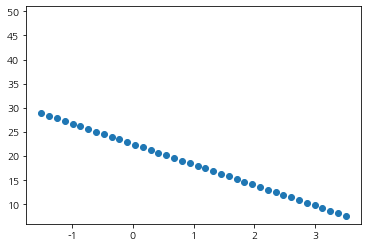

In [112]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])
# plt.savefig(GRAPHS_IMG_FILEPATH + "/04_relationship_most_impt_feat_preds.png")

# 신경망 모델을 이용한 회귀

In [113]:
def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-1.0 * x))

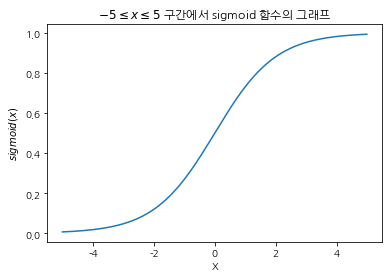

In [114]:
plt.plot(np.arange(-5, 5, 0.01),
         sigmoid(np.arange(-5, 5, 0.01)));
plt.title("$-5 \leq x \leq 5$ 구간에서 sigmoid 함수의 그래프")
plt.xlabel("X")
plt.ylabel("$sigmoid(x)$");
# plt.savefig(GRAPHS_IMG_FILEPATH + "05_sigmoid_function.png")

In [115]:
def init_weights(input_size: int, 
                 hidden_size: int) -> Dict[str, ndarray]:
    '''
    신경망 모델의 가중치 초기화
    '''
    weights: Dict[str, ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights

In [116]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]
                 ) -> Tuple[Dict[str, ndarray], float]:
    '''
    신경망 모델의 순방향 계산 및 손실값 계산을 단계별로 수행 
    '''
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [117]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    신경망의 각 파라미터에 대한 손실의 편미분을 계산
    '''    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdM2 = np.ones_like(forward_info['M2'])

    dLdM2 = dLdP * dPdM2
  
    dPdB2 = np.ones_like(weights['B2'])

    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    
    dM2dW2 = np.transpose(forward_info['O1'], (1, 0))
    
    dLdW2 = np.dot(dM2dW2, dLdP)

    dM2dO1 = np.transpose(weights['W2'], (1, 0)) 

    dLdO1 = np.dot(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info['N1']) * (1- sigmoid(forward_info['N1']))
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = np.ones_like(weights['B1'])
    
    dN1dM1 = np.ones_like(forward_info['M1'])
    
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = np.transpose(forward_info['X'], (1, 0)) 

    dLdW1 = np.dot(dM1dW1, dLdM1)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    
    return loss_gradients

In [118]:
def predict(X: ndarray, 
            weights: Dict[str, ndarray]) -> ndarray:
    '''
    직접 만든 신경망 모델로 예측값 계산 
    '''
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)

    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    return P

In [119]:
def train(X_train: ndarray, y_train: ndarray,
          X_test: ndarray, y_test: ndarray,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          return_scores: bool = False,
          seed: int = 1) -> None:

    if seed:
        np.random.seed(seed)

    start = 0

    # 가중치 초기화
    weights = init_weights(X_train.shape[1], 
                           hidden_size=hidden_size)

    # 데이터 섞기
    X_train, y_train = permute_data(X_train, y_train)
    

    losses = []
        
    val_scores = []

    for i in range(n_iter):

        # 배치 생성
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
    
        # 생성한 배치로 학습 수행
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, weights)
                val_scores.append(r2_score(preds, y_test))

    if return_weights:
        return losses, weights, val_scores
    
    return None

In [120]:
if TEST_ALL:
    num_iter = 10000
    test_every = 1000
    train_info = train(X_train, y_train, X_test, y_test,
                       n_iter=num_iter,
                       test_every = test_every,
                       learning_rate = 0.001,
                       batch_size=23, 
                       return_losses=False, 
                       return_weights=True, 
                       return_scores=False,
                       seed=80718)
    losses = train_info[0]
    weights = train_info[1]
    val_scores = train_info[2]

In [121]:
if TEST_ALL:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.ylim([-1,1])
    plt.plot(list(range(int(num_iter / test_every - 1))), val_scores); 
    plt.xlabel("배치 (000s)")
    plt.title("검증 점수")

### 학습률 조정

In [122]:
def r2_score_lr(learning_rate):
    train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=100000,
                   test_every = 100000,
                   learning_rate = learning_rate,
                   batch_size=23, 
                   return_losses=False, 
                   return_weights=True, 
                   return_scores=False,
                   seed=80718)
    weights = train_info[1]
    preds = predict(X_test, weights)
    return r2_score(y_test, preds)

In [123]:
if TEST_ALL:
    lrs = np.geomspace(1e-2, 1e-6, num=20)

In [124]:
if TEST_ALL:
    r2s = [r2_score_lr(lr) for lr in lrs]

In [125]:
if TEST_ALL:
    plt.semilogx(lrs, r2s)

## 모델 평가

In [126]:
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=10000,
                   test_every = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   return_scores=False,
                   seed=180807)
losses = train_info[0]
weights = train_info[1]

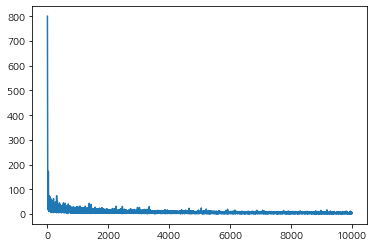

In [127]:
plt.plot(list(range(10000)), losses);

In [128]:
preds = predict(X_test, weights)

## 중요도가 높은 특징 찾기

절대값이 9보다 높은 두 가지가 가장 중요도 높은 특징의 조합이다.

In [129]:
weights['W2']

array([[  6.8818],
       [  7.3908],
       [  5.632 ],
       [  7.2358],
       [  7.6253],
       [  6.754 ],
       [  3.3251],
       [  9.7287],
       [  5.6011],
       [-10.2469],
       [  5.5645],
       [  5.6762],
       [ -4.4088]])

여기서는 인덱스 7과 9에 해당한다. 이들의 조합은 다음과 같다.

In [130]:
weights['W1'][7]

array([-3.3532e+00, -4.6775e-01,  5.4810e-01, -8.8043e-02,  1.7536e+00,
       -5.3111e+00, -9.4313e-01, -5.8730e-01, -1.2341e-03,  1.1375e+00,
       -5.2801e-01,  1.1592e+00,  1.6007e+00])

In [131]:
weights['W1'][9]

array([-2.6785,  3.9213,  2.2398, -3.6323, -0.2241,  3.1889,  0.3231,
        0.4316, -1.9733,  0.2403, -1.4463, -0.5084,  1.5561])

In [132]:
print("평균절대오차:", round(mae(preds, y_test), 4), "\n"
      "제곱근 평균제곱오차:", round(rmse(preds, y_test), 4))

평균절대오차: 2.5951 
제곱근 평균제곱오차: 3.8851


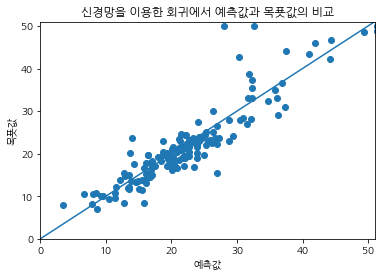

In [133]:
plt.xlabel("예측값")
plt.ylabel("목푯값")
plt.title("신경망을 이용한 회귀에서 예측값과 목푯값의 비교")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);
# plt.savefig(GRAPHS_IMG_FILEPATH + "07_neural_network_regression_preds_vs_target.png");

In [62]:
np.round(np.mean(np.array(np.abs(preds - y_test))), 4)

2.5951

In [63]:
np.round(np.mean(np.array(np.power(preds - y_test, 2))), 4)

15.0943

## 중요도가 높은 특징과 목푯값의 이론적 관계

In [135]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = np.concatenate([a, b], axis=1)
preds_test = predict(test_feature, weights)[:, 0]

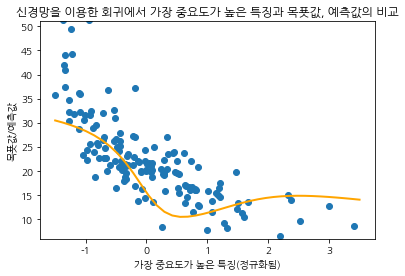

In [136]:
plt.scatter(X_test[:, 12], preds)
plt.plot(np.array(test_feature[:, -1]), preds_test, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("가장 중요도가 높은 특징(정규화됨)")
plt.ylabel("목푯값/예측값")
plt.title("신경망을 이용한 회귀에서 가장 중요도가 높은 특징과 목푯값, 예측값의 비교");
# plt.savefig(GRAPHS_IMG_FILEPATH + "08_neural_network_regression_impt_feat_vs_preds.png")